### 1. Wczytanie bibliotek i załadowanie danych

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
from kagglehub import KaggleDatasetAdapter
import kagglehub

file_path = "HR Employee Attrition.csv"

df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "whenamancodes/hr-employee-attrition",
  file_path,
)

### 2. Przygotowanie danych

In [22]:
# Wybranie cechy którą bedziemy predykować
target = 'MonthlyIncome'
X = df.drop(columns=[target])
y = df[target]

In [23]:
# Rozróżnienie kolumn numerycznych i kategorycznych
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

In [24]:
# Pipeline preprocessingu (OneHot dla kategorii)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

In [25]:
# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Transformacja danych
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [27]:
# nazwy cech po transformacji
try:
    cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    feature_names = np.r_[numeric_features, cat_names]
except:
    feature_names = [f"Feature_{i}" for i in range(X_train_processed.shape[1])]

### 3. Porównanie regresjii liniowej i Ridge

In [28]:
lin_reg = LinearRegression()
ridge_reg = Ridge(alpha=10.0) # alpha to siła regularyzacji

lin_reg.fit(X_train_processed, y_train)
ridge_reg.fit(X_train_processed, y_train)

# Predykcje
y_pred_lin = lin_reg.predict(X_test_processed)
y_pred_ridge = ridge_reg.predict(X_test_processed)

# Wyniki
r2_lin = r2_score(y_test, y_pred_lin)
r2_ridge = r2_score(y_test, y_pred_ridge)

rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print(f"--- WYNIKI ---")
print(f"Linear Regression: R2 = {r2_lin:.4f}, RMSE = {rmse_lin:.2f}")
print(f"Ridge Regression:  R2 = {r2_ridge:.4f}, RMSE = {rmse_ridge:.2f}")

--- WYNIKI ---
Linear Regression: R2 = 0.9378, RMSE = 1165.71
Ridge Regression:  R2 = 0.9355, RMSE = 1187.37


### 4. Analiza ważnosci Cech RIDGE

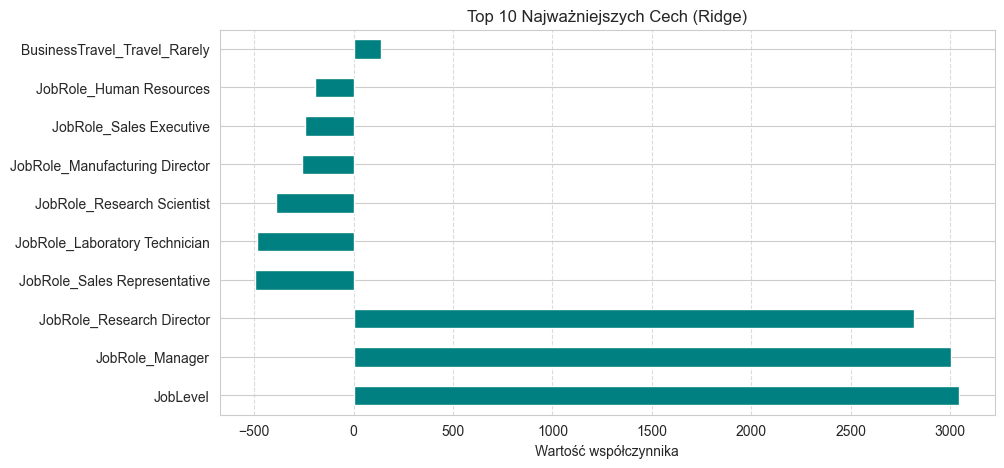

In [29]:
coefs = pd.Series(ridge_reg.coef_, index=feature_names)
top_features = coefs.abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
coefs[top_features.index].plot(kind='barh', color='teal')
plt.title("Top 10 Najważniejszych Cech (Ridge)")
plt.xlabel("Wartość współczynnika")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


### 5.1 Analiza reszt regresja liniowa


--- ANALIZA RESZT : REGRESJA LINIOWA---
Test Shapiro-Wilka (Normalność): p-value = 2.5949e-05
  -> Reszty NIE mają rozkładu normalnego (p < 0.05).
Test Durbin-Watson (Autokorelacja): 2.13
  (Wartość bliska 2.0 oznacza brak autokorelacji. < 1.5 to korelacja dodatnia)


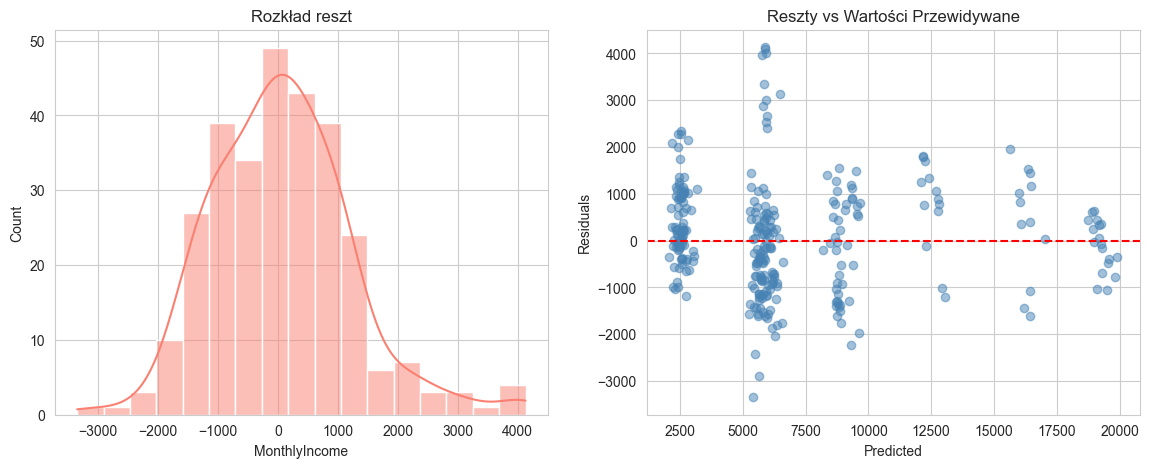

In [30]:
residuals = y_test - y_pred_lin

# Test normalności (Shapiro-Wilk)
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"\n--- ANALIZA RESZT : REGRESJA LINIOWA---")
print(f"Test Shapiro-Wilka (Normalność): p-value = {shapiro_p:.4e}")
if shapiro_p > 0.05:
    print("  -> Nie ma podstaw do odrzucenia hipotezy o normalności reszt (rozkład normalny).")
else:
    print("  -> Reszty NIE mają rozkładu normalnego (p < 0.05).")

# Test autokorelacji (Durbin-Watson)
dw_stat = durbin_watson(residuals)
print(f"Test Durbin-Watson (Autokorelacja): {dw_stat:.2f}")
print("  (Wartość bliska 2.0 oznacza brak autokorelacji. < 1.5 to korelacja dodatnia)")

# Wykresy reszt
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(residuals, kde=True, ax=ax[0], color='salmon')
ax[0].set_title("Rozkład reszt")
ax[1].scatter(y_pred_lin, residuals, alpha=0.5, color='steelblue')
ax[1].axhline(0, color='red', linestyle='--')
ax[1].set_title("Reszty vs Wartości Przewidywane")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Residuals")
plt.show()

### 5.2 Analiza reszt Ridge


--- ANALIZA RESZT : RIDGE---
Test Shapiro-Wilka (Normalność): p-value = 3.9605e-05
  -> Reszty NIE mają rozkładu normalnego (p < 0.05).
Test Durbin-Watson (Autokorelacja): 2.12
  (Wartość bliska 2.0 oznacza brak autokorelacji. < 1.5 to korelacja dodatnia)


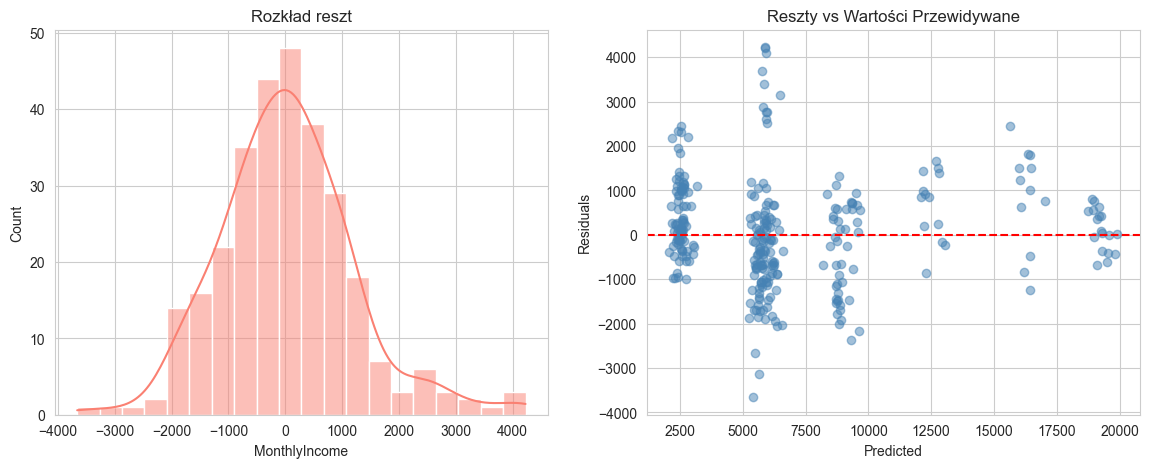

In [31]:
residuals = y_test - y_pred_ridge

# Test normalności (Shapiro-Wilk)
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"\n--- ANALIZA RESZT : RIDGE---")
print(f"Test Shapiro-Wilka (Normalność): p-value = {shapiro_p:.4e}")
if shapiro_p > 0.05:
    print("  -> Nie ma podstaw do odrzucenia hipotezy o normalności reszt (rozkład normalny).")
else:
    print("  -> Reszty NIE mają rozkładu normalnego (p < 0.05).")

# Test autokorelacji (Durbin-Watson)
dw_stat = durbin_watson(residuals)
print(f"Test Durbin-Watson (Autokorelacja): {dw_stat:.2f}")
print("  (Wartość bliska 2.0 oznacza brak autokorelacji. < 1.5 to korelacja dodatnia)")

# Wykresy reszt
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(residuals, kde=True, ax=ax[0], color='salmon')
ax[0].set_title("Rozkład reszt")
ax[1].scatter(y_pred_lin, residuals, alpha=0.5, color='steelblue')
ax[1].axhline(0, color='red', linestyle='--')
ax[1].set_title("Reszty vs Wartości Przewidywane")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Residuals")
plt.show()

### 6. Różnice wyników w zależnosci od saklowanych danych

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

ridge_reg_scaled = Ridge(alpha=10.0)
ridge_reg_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = ridge_reg_scaled.predict(X_test_scaled)


lin_reg_scaled = LinearRegression()
lin_reg_scaled.fit(X_train_scaled, y_train)
y_pred_scaled_lin = lin_reg_scaled.predict(X_test_scaled)


ridge_no_scale_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_scale_rmse = np.sqrt(mean_squared_error(y_test, y_pred_scaled))

lin_no_scale_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lin))
lin_scale_rmse = np.sqrt(mean_squared_error(y_test, y_pred_scaled_lin))

r2_ridge = r2_score(y_test, y_pred_ridge)
r2_ridge_scale = r2_score(y_test, y_pred_scaled)

r2_lin = r2_score(y_test, y_pred_lin)
r2_lin_scale = r2_score(y_test, y_pred_scaled_lin)


print(f"\n--- WPŁYW SKALOWANIA (RIDGE) ---")
print(f"Bez skalowania: RMSE = {ridge_no_scale_rmse:.2f} R2 ={r2_ridge:.4f}")
print(f"Zeskalowane:    RMSE = {ridge_scale_rmse:.2f} R2 ={r2_ridge_scale:.4f}")
print("###################################################################")
print(f"\n--- WPŁYW SKALOWANIA (REGRESJA LINIOWA) ---")
print(f"Bez skalowania: RMSE = {lin_no_scale_rmse:.2f} R2 ={r2_lin:.4f}")
print(f"Zeskalowane:    RMSE = {lin_scale_rmse:.2f} R2 ={r2_lin_scale:.4f}")


--- WPŁYW SKALOWANIA (RIDGE) ---
Bez skalowania: RMSE = 1187.37 R2 =0.9355
Zeskalowane:    RMSE = 1160.21 R2 =0.9384
###################################################################

--- WPŁYW SKALOWANIA (REGRESJA LINIOWA) ---
Bez skalowania: RMSE = 1165.71 R2 =0.9378
Zeskalowane:    RMSE = 1165.71 R2 =0.9378


### 7. Wizualizacja wyników

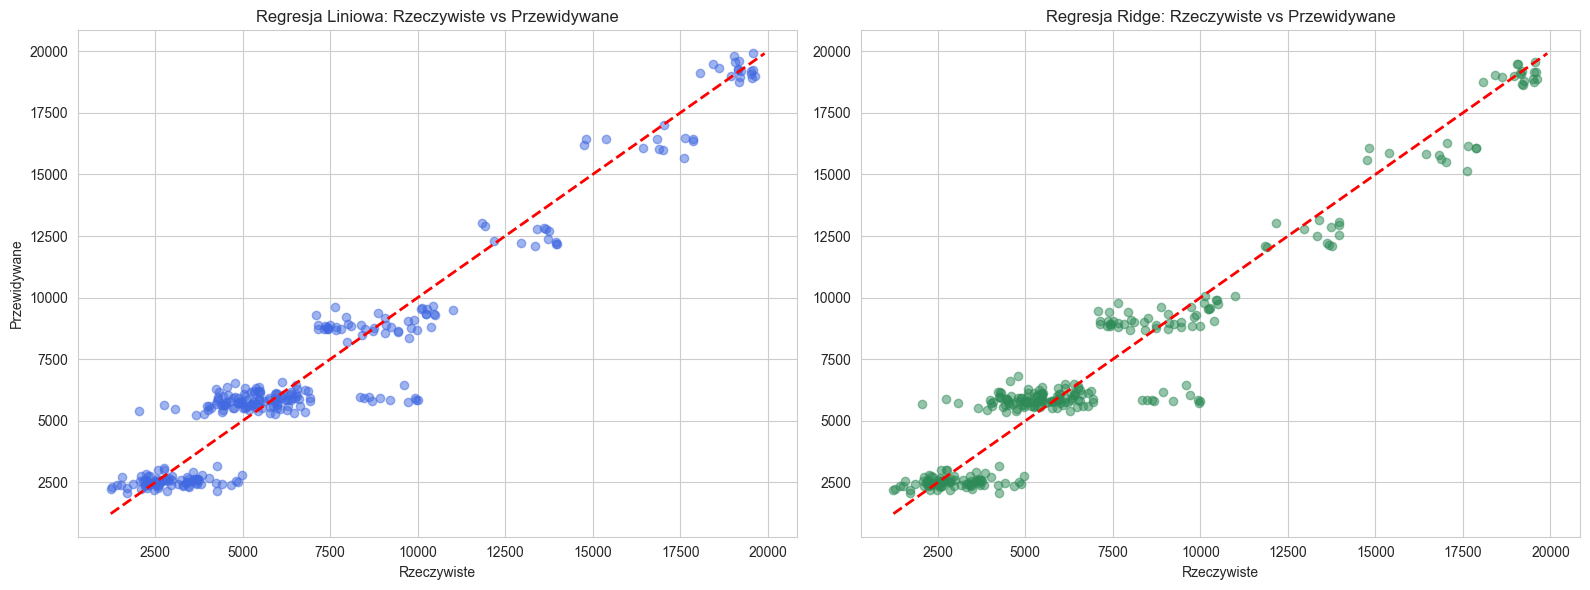

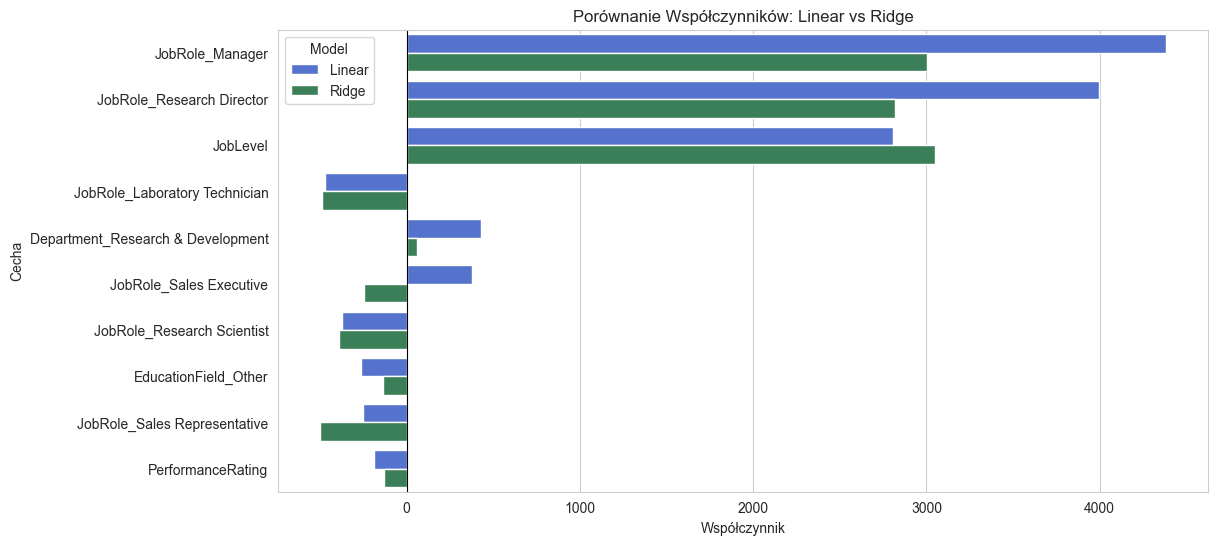

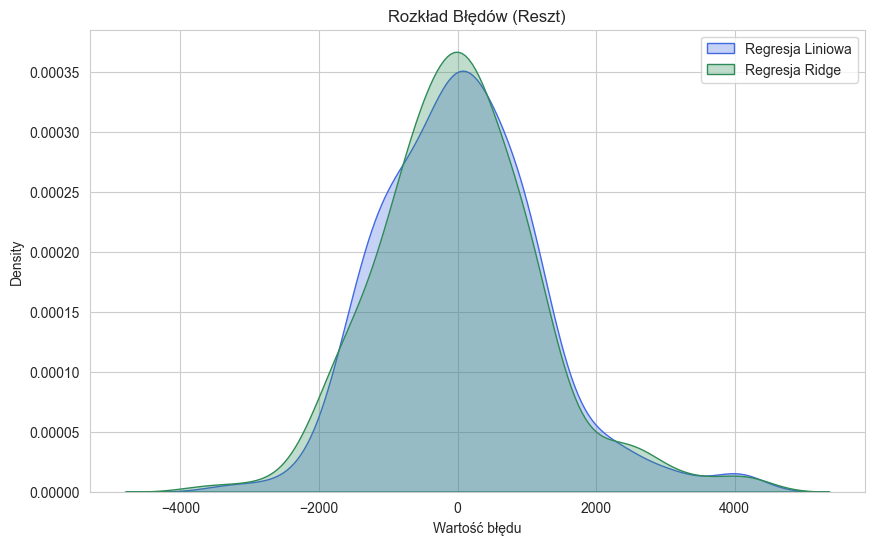

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# --- WYKRES 1: Rzeczywiste vs Przewidywane ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
min_val = min(y_test.min(), y_pred_lin.min(), y_pred_ridge.min())
max_val = max(y_test.max(), y_pred_lin.max(), y_pred_ridge.max())

# Liniowa
axes[0].scatter(y_test, y_pred_lin, alpha=0.5, color='royalblue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[0].set_title('Regresja Liniowa: Rzeczywiste vs Przewidywane')
axes[0].set_xlabel('Rzeczywiste')
axes[0].set_ylabel('Przewidywane')

# Ridge
axes[1].scatter(y_test, y_pred_ridge, alpha=0.5, color='seagreen')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[1].set_title('Regresja Ridge: Rzeczywiste vs Przewidywane')
axes[1].set_xlabel('Rzeczywiste')

plt.tight_layout()
plt.show()

# --- WYKRES 2: Współczynniki (Top 10) ---
df_coefs = pd.DataFrame({
    'Cecha': feature_names,
    'Linear': lin_reg.coef_,
    'Ridge': ridge_reg.coef_
})
df_coefs['abs_val'] = df_coefs['Linear'].abs()
df_top_coefs = df_coefs.sort_values('abs_val', ascending=False).head(10)
df_melted = df_top_coefs.melt(id_vars='Cecha', value_vars=['Linear', 'Ridge'], var_name='Model', value_name='Współczynnik')

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='Współczynnik', y='Cecha', hue='Model', palette=['royalblue', 'seagreen'])
plt.title('Porównanie Współczynników: Linear vs Ridge')
plt.axvline(0, color='black', linewidth=0.8)
plt.show()

# --- WYKRES 3: Gęstość Reszt ---
residuals_lin = y_test - y_pred_lin
residuals_ridge = y_test - y_pred_ridge

plt.figure(figsize=(10, 6))
sns.kdeplot(residuals_lin, label='Regresja Liniowa', fill=True, color='royalblue', alpha=0.3)
sns.kdeplot(residuals_ridge, label='Regresja Ridge', fill=True, color='seagreen', alpha=0.3)
plt.title('Rozkład Błędów (Reszt)')
plt.xlabel('Wartość błędu')
plt.legend()
plt.show()